In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

for i in inspector.get_columns('measurement'): print(i["name"], i["type"])
print("-"*12)
for i in inspector.get_columns('station'): print(i["name"], i["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# query most recent entry
last_entry = engine.execute("SELECT * FROM measurement ORDER BY date DESC").first()

# compute date 12 months ago
last_12_months = dt.datetime.strptime(last_entry.date, '%Y-%m-%d') + dt.timedelta(days=-365)


In [15]:
stmt = session.query(Measurement).filter(Measurement.date >= last_12_months).statement

measurement_df = pd.read_sql(stmt, session.bind)

measurement_df = measurement_df.sort_values("date").set_index("date")

measurement_df


,id,station,prcp,tobs
date,,,,
2016-08-24,2365,USC00519397,0.08,79.0
2016-08-24,8826,USC00517948,NaN,78.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-24,7332,USC00514830,2.28,80.0
2016-08-24,5092,USC00513117,2.15,76.0
...,...,...,...,...
2017-08-22,12186,USC00519523,0.00,82.0
2017-08-23,12187,USC00519523,0.08,82.0
2017-08-23,2724,USC00519397,0.00,81.0


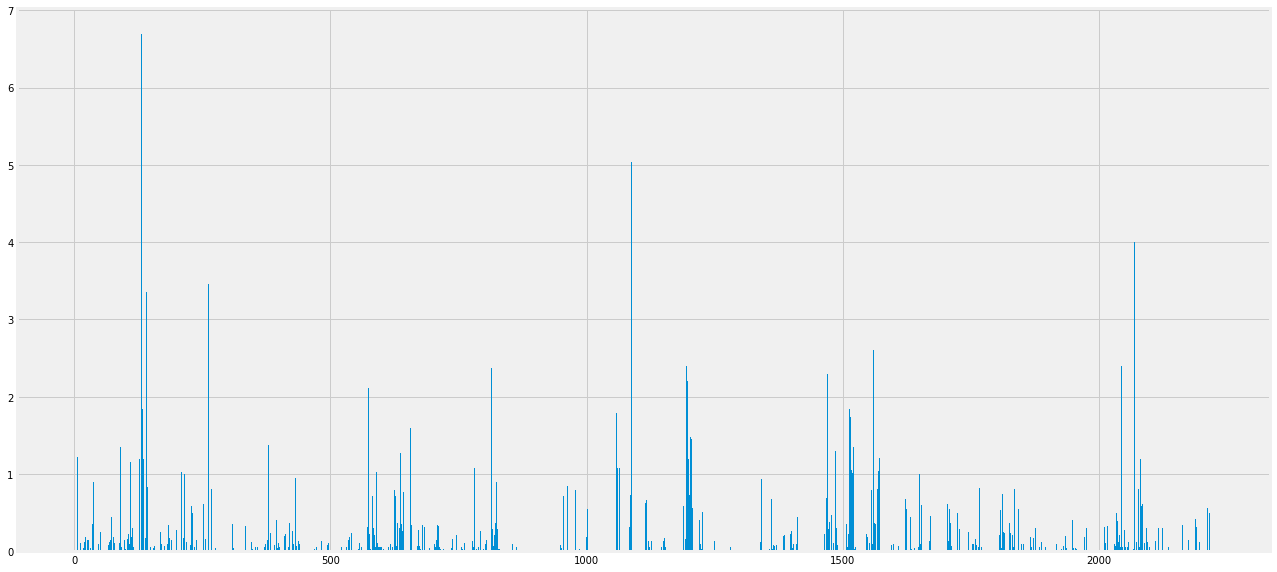

In [17]:
fig, ax = plt.subplots(figsize=(20,10))

row, col = measurement_df.shape

x_axis = np.arange(0, row, step=1)
ax.bar(x_axis, measurement_df.prcp)

plt.show()


![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()


,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct(Measurement.station).count()


9

In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = station_activity[0][0]

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).first()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).first()

summary = f'''
The most active station is {most_active} with
lowest temperature recorded: {min_temp[0]:.2f}
highest temperature recorded: {max_temp[0]:.2f}
average temperature: {avg_temp[0]:.2f}
'''

print(summary)



The most active station is USC00519281 with
lowest temperature recorded: 54.00
highest temperature recorded: 85.00
average temperature: 71.66



In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

obs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station) \
    .filter(Measurement.tobs.isnot(None)).order_by(func.count(Measurement.tobs).desc()).all()

obs


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [82]:
tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= last_12_months)\
    .filter(Measurement.station == obs[0][0]).all()



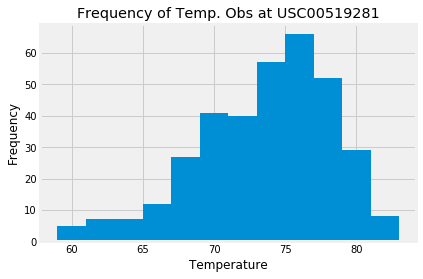

In [97]:
fig, ax = plt.subplots()

pd.DataFrame(tobs_data).hist(bins=12, ax=ax)

ax.set_title(f"Frequency of Temp. Obs at {obs[0][0]}")
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")

plt.show()


In [72]:
# station_activity
measurement_df.loc[measurement_df["tobs"] == 0 , :]

measurement_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 2016-08-24 to 2017-08-23
Data columns (total 4 columns):
id         2223 non-null int64
station    2223 non-null object
prcp       2015 non-null float64
tobs       2223 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 166.8+ KB


![precipitation](Images/station-histogram.png)

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
